#### About

#### Load libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *

In [3]:
# show versions
print('fastai:', fastai.__version__)
print('pytorch:', torch.__version__)
print('python:', sys.version.split('|')[0])

fastai: 1.0.45
pytorch: 1.0.0
python: 3.6.5 


#### Examine dataset file structure

In [4]:
# download the dataset
! mkdir -p /home/ubuntu/.fastai/data; 
! cd /home/ubuntu/.fastai/data; wget -nc https://data.mendeley.com/datasets/rscbjbr9sj/2/files/41d542e7-7f91-47f6-9ff2-dd8e5a5a7861/ChestXRay2017.zip; unzip -n -q ChestXRay2017.zip
! find /home/ubuntu/.fastai/data/chest_xray -name .DS_Store -exec rm {} \;

File ‘ChestXRay2017.zip’ already there; not retrieving.



In [5]:
path=Path('/home/ubuntu/.fastai/data/chest_xray')

In [6]:
# see what files we've got
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/chest_xray/test'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/models')]

In [7]:
Path(path/'train').ls()

[PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/NORMAL'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/PNEUMONIA')]

In [8]:
# show some sample paths to the images
get_image_files(path/'train/NORMAL')[:5]

[PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/NORMAL/IM-0545-0001-0001.jpeg'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/NORMAL/IM-0427-0001.jpeg'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/NORMAL/IM-0648-0001.jpeg'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/NORMAL/IM-0660-0001.jpeg'),
 PosixPath('/home/ubuntu/.fastai/data/chest_xray/train/NORMAL/IM-0637-0001.jpeg')]

In [9]:
# see how many files in each category
for dirname in os.listdir(path/'train'):
    print('train', dirname, len(os.listdir(path/'train'/dirname)))
for dirname in os.listdir(path/'test'):
    print('test ', dirname, len(os.listdir(path/'test'/dirname)))

train NORMAL 1349
train PNEUMONIA 3883
test  NORMAL 234
test  PNEUMONIA 390


#### Examine image size distribution

torch.Size([3, 1580, 1924])


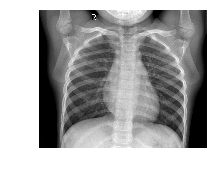

In [10]:
# look the shape and visualize one image
img = open_image(get_image_files(path/'train/NORMAL')[0])
print(img.shape)
img.show()

In [11]:
# calculate average, minimum, and maximum for width and height of images
widths, heights = [], []
width_min, width_max = np.inf, -np.inf
height_min, height_max = np.inf, -np.inf

for ds in ['train', 'test']:
    for dirname in os.listdir(path/ds):
        for filename in os.listdir(path/ds/dirname):
            image = PIL.Image.open(os.path.join(path/ds/dirname, filename))
            widths.append(image.size[0])
            heights.append(image.size[1])

print('avg (width, height): ', (np.mean(widths), np.mean(heights)))
print('std (width, height): ', (np.std(widths), np.std(heights)))
print('width (min, max): ', (np.min(widths), np.max(widths)))
print('height (min, max): ', (np.min(heights), np.max(heights)))

avg (width, height):  (1327.880806010929, 970.6890368852459)
std (width, height):  (363.46988369451225, 383.35938110959034)
width (min, max):  (384, 2916)
height (min, max):  (127, 2713)


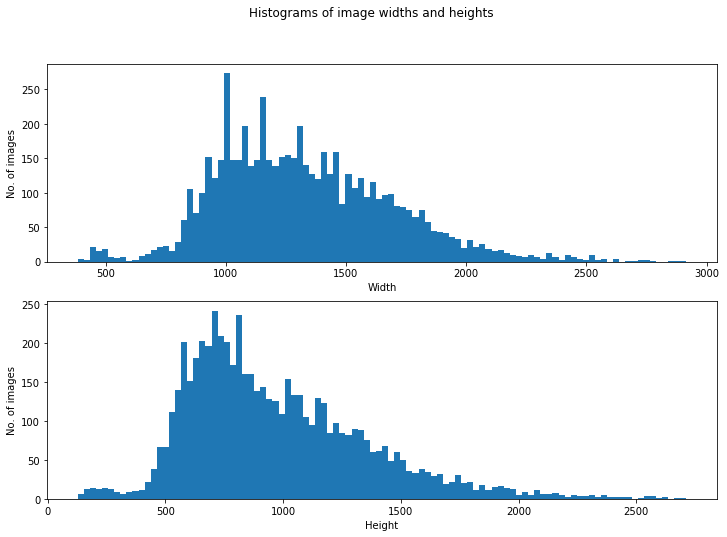

In [12]:
# plot histograms of heights and widths.
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Histograms of image widths and heights')
 
ax1.hist(widths, bins=100); ax1.set_xlabel('Width'); ax1.set_ylabel('No. of images')
ax2.hist(heights, bins=100); ax2.set_xlabel('Height'); ax2.set_ylabel('No. of images')
 
plt.show()

#### Create datablock

In [13]:
# set hyperparamters
np.random.seed(42)
size = 224
bs = 64
num_workers = 4

In [14]:
# define data augmentation transformations
tfms = get_transforms()

In [15]:
# use the labeled test data as the validation set
src = (ImageItemList.from_folder(path)
       .split_by_folder(train='train', valid='test')
       .label_from_folder())

In [16]:
data = (src.transform(tfms, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

#### Do sanity checks

In [17]:
# verify datasets loaded properly
print(len(data.train_ds))
print(len(data.valid_ds))

5232
624


In [18]:
data.classes

['NORMAL', 'PNEUMONIA']

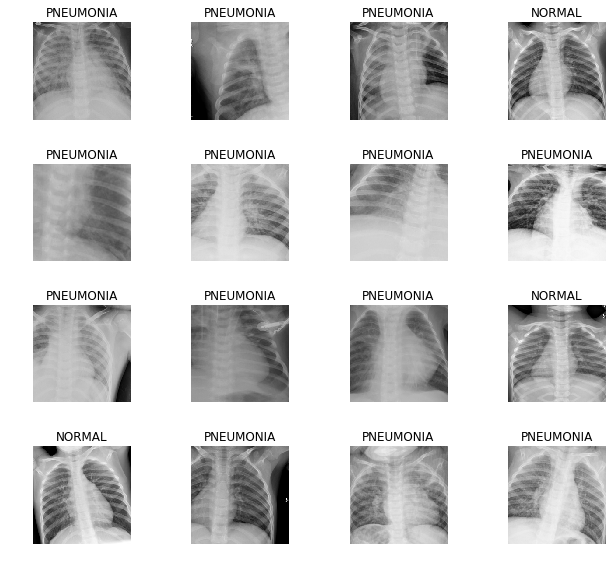

In [19]:
data.show_batch(rows=4, figsize=(9,8))

#### Create model

In [20]:
# define architecture
arch = models.resnet50

In [21]:
# create learner
learn = create_cnn(data, arch, ps=0.7, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-04


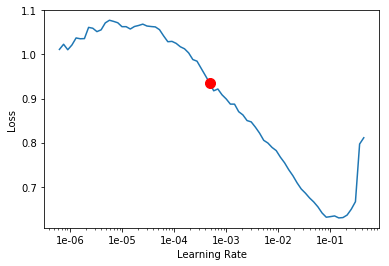

In [22]:
# find ideal learning rate
learn.lr_find()
learn.recorder.plot()

In [23]:
lr = 1e-2

## size 224

#### Train on frozen model

In [24]:
# first fit the head of the model
learn.fit_one_cycle(8, slice(lr))

epoch,train_loss,valid_loss,accuracy
1,0.310864,0.465951,0.873397
2,0.198392,0.446740,0.892628
3,0.174241,0.416408,0.876603
4,0.128210,0.364266,0.894231
5,0.108556,0.273995,0.916667
6,0.079175,0.275426,0.910256
7,0.067047,0.295385,0.915064
8,0.062748,0.292452,0.913462


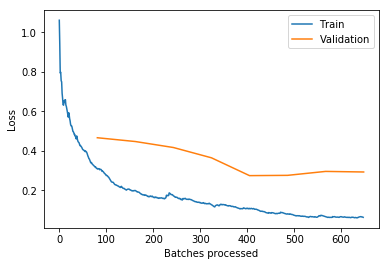

In [25]:
learn.recorder.plot_losses()

In [26]:
learn.save('stage-1-reg')

#### Train on unfrozen model

In [27]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


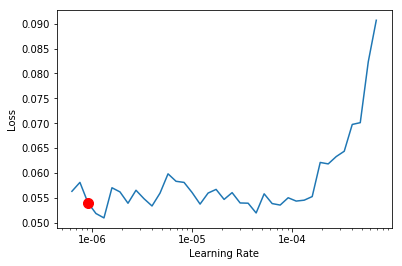

In [28]:
# find ideal learning rate
learn.lr_find()
learn.recorder.plot()

In [29]:
# now fit across the entire model
learn.fit_one_cycle(3, max_lr=slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy
1,0.061588,0.307041,0.910256
2,0.058300,0.297312,0.908654
3,0.055927,0.266841,0.921474


In [30]:
learn.save('stage-2-reg')

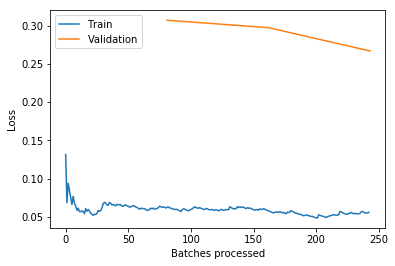

In [31]:
learn.recorder.plot_losses()

#### Look at results

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

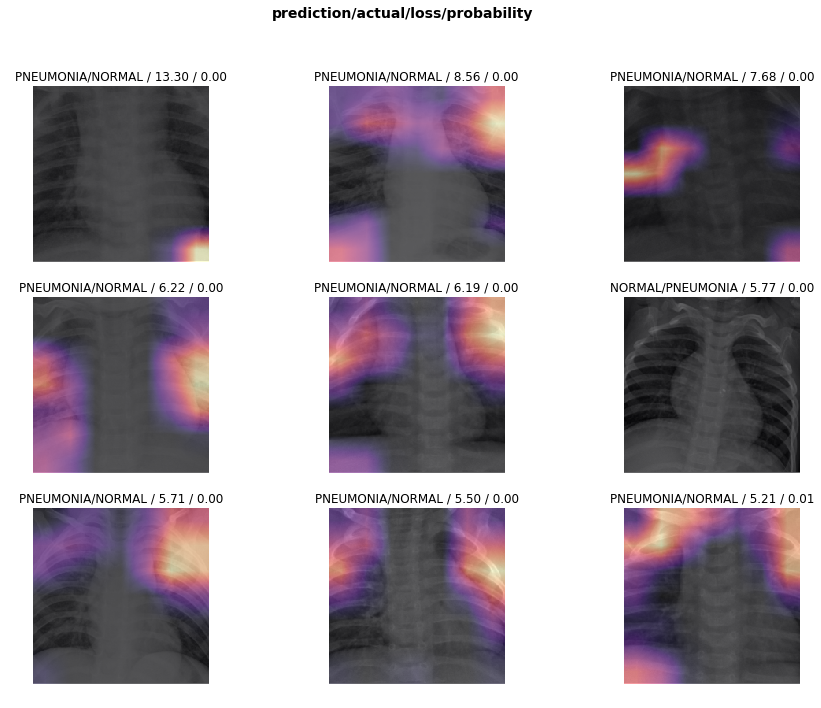

In [33]:
interp.plot_top_losses(9, figsize=(15,11))

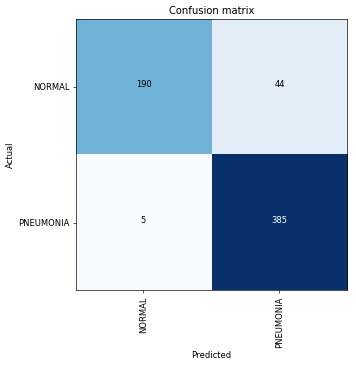

In [34]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [35]:
# print accuracy
correct_preds = interp.pred_class == interp.y_true
sum(correct_preds.numpy()) / len(correct_preds)

0.9214743589743589

In [36]:
# calculate precision and recall
(tn, fp), (fn, tp) = interp.confusion_matrix()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

Precision: 0.8974
Recall: 0.9872


#### Look at results with TTA

In [37]:
interp_tta = ClassificationInterpretation.from_learner(learn, tta=True)
losses,idxs = interp_tta.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

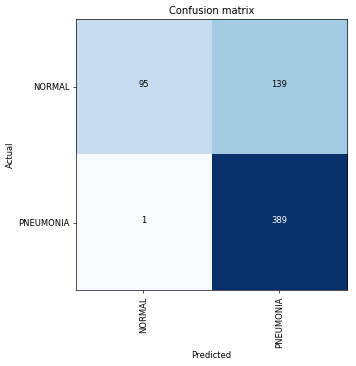

In [38]:
interp_tta.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [39]:
# print accuracy
correct_preds = interp_tta.pred_class == interp_tta.y_true
sum(correct_preds.numpy()) / len(correct_preds)

0.7756410256410257

In [40]:
# calculate precision and recall
(tn, fp), (fn, tp) = interp_tta.confusion_matrix()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

Precision: 0.7367
Recall: 0.9974


## size 512

In [41]:
# set hyperparamters
np.random.seed(42)
size = 512
bs = 24
num_workers = 4

In [42]:
data = (src.transform(tfms, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

In [43]:
learn = create_cnn(data, arch, metrics=accuracy).load('stage-2-reg')

In [44]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06


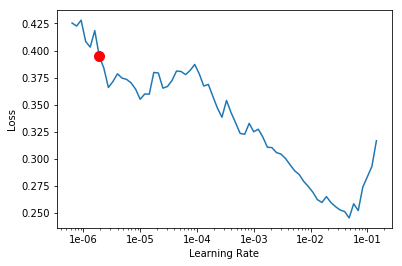

In [45]:
# find ideal learning rate
learn.lr_find()
learn.recorder.plot()

In [46]:
lr = 5e-3

#### Train on frozen model

In [47]:
# first fit the head of the model
learn.fit_one_cycle(8, slice(lr))

epoch,train_loss,valid_loss,accuracy
1,0.129341,0.293164,0.907051
2,0.106940,0.403993,0.902244
3,0.104411,0.359015,0.913462
4,0.079428,0.575542,0.868590
5,0.058377,0.469181,0.905449
6,0.052055,0.445834,0.902244
7,0.049699,0.477001,0.897436
8,0.040929,0.444172,0.903846


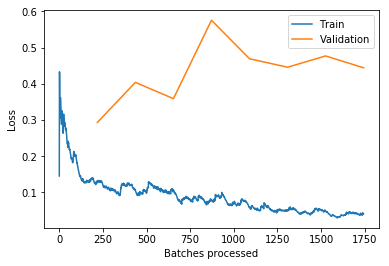

In [48]:
learn.recorder.plot_losses()

In [49]:
learn.save('stage-3-reg')

#### Train on unfrozen model

In [50]:
learn.unfreeze()

In [52]:
# find ideal learning rate
learn.lr_find(stop_div=False)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 11.17 GiB total capacity; 10.73 GiB already allocated; 31.19 MiB free; 103.36 MiB cached)

In [23]:
# now fit across the entire model
learn.fit_one_cycle(3, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.102008,0.714864,0.804487
2,0.055244,0.310354,0.908654
3,0.026548,0.456951,0.879808


In [24]:
learn.save('stage-4-reg')

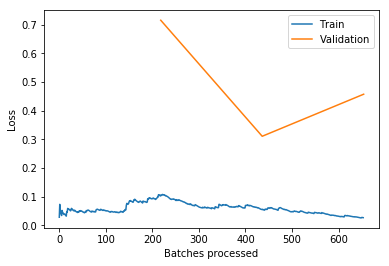

In [25]:
learn.recorder.plot_losses()

#### Look at results

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

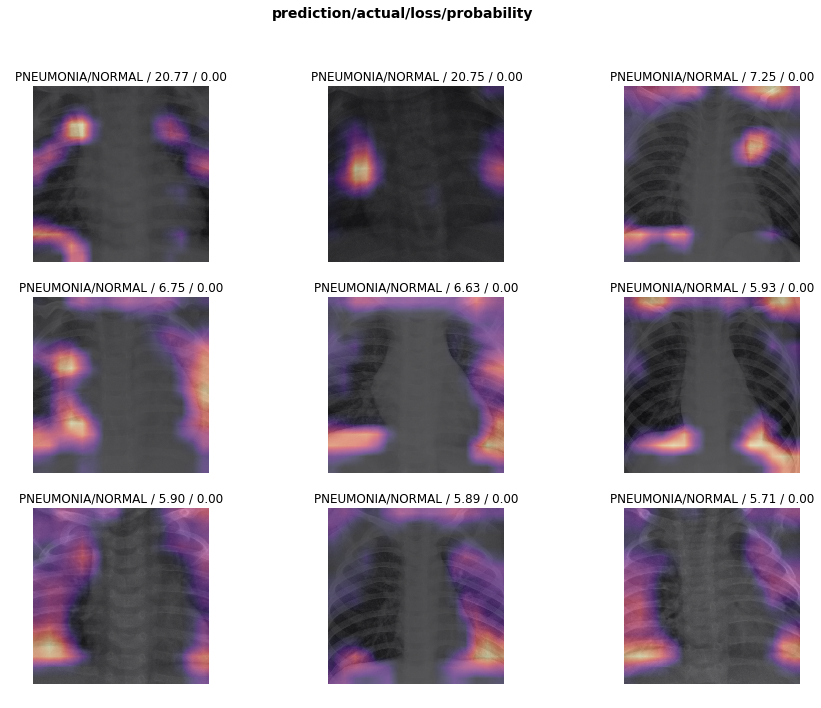

In [27]:
interp.plot_top_losses(9, figsize=(15,11))

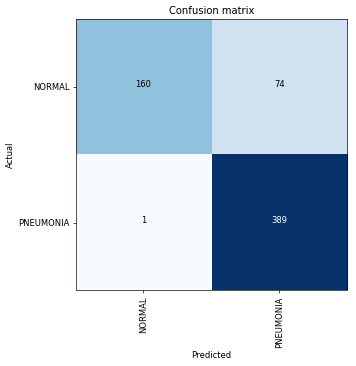

In [28]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [29]:
# print accuracy
correct_preds = interp.pred_class == interp.y_true
sum(correct_preds.numpy()) / len(correct_preds)

0.8798076923076923

In [30]:
# calculate precision and recall
(tn, fp), (fn, tp) = interp.confusion_matrix()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

Precision: 0.8402
Recall: 0.9974


#### Look at results with TTA

In [31]:
interp_tta = ClassificationInterpretation.from_learner(learn, tta=True)
losses,idxs = interp_tta.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

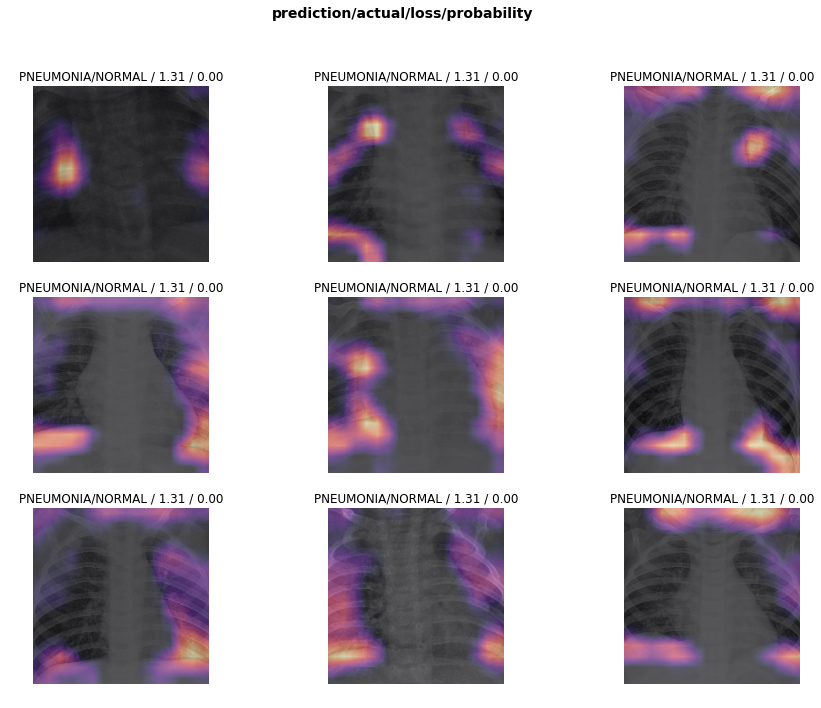

In [32]:
interp_tta.plot_top_losses(9, figsize=(15,11))

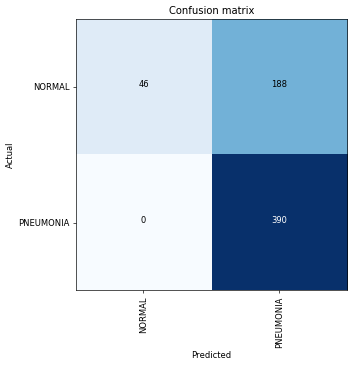

In [33]:
interp_tta.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [34]:
# print accuracy
correct_preds = interp_tta.pred_class == interp_tta.y_true
sum(correct_preds.numpy()) / len(correct_preds)

0.6987179487179487

In [35]:
# calculate precision and recall
(tn, fp), (fn, tp) = interp_tta.confusion_matrix()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

Precision: 0.6747
Recall: 1.0000
